In [131]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from numpy import log
from numpy.random import choice

import matplotlib.pyplot as plt

import copy

In [132]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0],bias=False)
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1],bias=False))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size,bias=False)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [133]:
INPUT_SIZE=784
HIDDEN_SIZES=[256,256]
OUTPUT_SIZE=10
BATCH_SIZE=500
LEARNING_RATE=0.05
MOMENTUM=0.95
NUM_EPOCHS=200

STOPPING_CRITERIA=0.1
SGD_ITERATIONS=500
SAMPLE_SIZE=5
SIGMA=1e-3

M_TRAIN=10000
M_TEST=2000

In [134]:
TRAIN_DATASET = torchvision.datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
TEST_DATASET = torchvision.datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

SUBSET_TRAIN_ID=list(range(M_TRAIN))
SUBSET_TEST_ID=list(range(M_TEST))

subset_train_dataset=Subset(TRAIN_DATASET, SUBSET_TRAIN_ID)
subset_test_dataset=Subset(TEST_DATASET, SUBSET_TEST_ID)

TRAIN_DATASET_LOADER = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, shuffle=True)
TEST_DATASET_LOADER = DataLoader(TEST_DATASET, batch_size=1, shuffle=False) 

In [135]:
def network_parameters(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            for l in para[1].detach().tolist():
                network_weights+=l
        else:
            network_weights+=para[1].detach().tolist()
    return network_weights

In [136]:
def train_epoch(model,optimizer,loader):
    def normalized_CrossEntropyLoss(predictions,targets):
        return nn.CrossEntropyLoss()(predictions,targets)/log(10)
    for xs, ys in loader:  
        xs = xs.reshape(-1, 28*28)
        outputs = model(xs)
        loss = normalized_CrossEntropyLoss(outputs, ys)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

def risk(model,loader):
    def normalized_CrossEntropyLoss(predictions,targets):
        return nn.CrossEntropyLoss()(predictions,targets)/log(10)
    with torch.no_grad():
        loss=0
        n=0
        for xs, ys in loader:
            xs = xs.reshape(-1, 28*28)
            outputs = model(xs)
            loss+=normalized_CrossEntropyLoss(outputs,ys)
            n+=1
    return loss/n


def SGD_Alg(model,optimizer,dataset,stopping_criteria,batch_size,sgd_iterations,stop_at_zero=False):
    n_dataset=len(dataset)
    ind=list(range(n_dataset))
    for i in range(sgd_iterations):
        n_ind=len(ind)
        if n_ind>=batch_size:
            sample_ind=choice(ind,batch_size,replace=False)
            subset=Subset(dataset,sample_ind)
            subset_loader=DataLoader(subset,batch_size=batch_size)
            loss=train_epoch(model,optimizer,subset_loader)
            for entry in sample_ind:
                ind.remove(entry)
        elif n_ind>0:
            subset=Subset(dataset,ind)
            subset_loader=DataLoader(subset,batch_size=batch_size)
            loss=train_epoch(model,optimizer,subset_loader)
            ind=[]
        else:
            if stop_at_zero:
                break
            else:
                ind=list(range(n_dataset))
        if loss<stopping_criteria:
            break

def get_weights(model,dataset,alpha,stopping_criteria,sgd_iterations,batch_size,learning_rate,momentum):

    n=len(dataset)
    
    subsetInd=list(range(int(n*alpha)))
    subset=Subset(dataset,subsetInd)

    model_prefix=copy.deepcopy(model)
    opt_prefix = SGD(model_prefix.parameters(), lr=learning_rate,momentum=momentum)
    SGD_Alg(model_prefix,opt_prefix,subset,stopping_criteria,batch_size,sgd_iterations,stop_at_zero=True)
    model_base=copy.deepcopy(model_prefix)
    opt_base = SGD(model_base.parameters(), lr=learning_rate,momentum=momentum)
    SGD_Alg(model_base,opt_base,dataset,stopping_criteria,batch_size,sgd_iterations)

    w_base=network_parameters(model_base)
    w_prefix=network_parameters(model_prefix)

    return w_base,w_prefix,model_base

In [137]:
def get_bound(base_model,train_loader,test_loader,alpha,dataset,stopping_criteria,sigma,sgd_iterations,batch_size,learning_rate,momentum):

    w_S,w_alpha,base_model=get_weights(base_model,dataset,alpha,stopping_criteria,sgd_iterations,batch_size,learning_rate,momentum)

    empirical_risk=risk(base_model,test_loader)
    test_risk=risk(base_model,test_loader)

    KL=np.linalg.norm(np.array(w_S)-np.array(w_alpha))**2/(sigma*2)
    return test_risk, empirical_risk, empirical_risk+np.sqrt(2*KL*sigma**2/len(dataset))


In [138]:
ALPHA_VALUES=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
test_losses=np.zeros_like(ALPHA_VALUES)
empirical_losses=np.zeros_like(ALPHA_VALUES)
bounds=np.zeros_like(ALPHA_VALUES)
for k,alpha in enumerate(ALPHA_VALUES):
    for n in range(SAMPLE_SIZE):
        BASE_MODEL=NeuralNet(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
        ReLU_glorot_init(BASE_MODEL)
        test_loss, empirical_loss, bound=get_bound(BASE_MODEL,TRAIN_DATASET,TEST_DATASET_LOADER,alpha,TRAIN_DATASET,STOPPING_CRITERIA,SIGMA,SGD_ITERATIONS,BATCH_SIZE,LEARNING_RATE,MOMENTUM)
        test_losses[k]+=test_loss/SAMPLE_SIZE
        empirical_losses[k]+=empirical_loss/SAMPLE_SIZE
        bounds[k]+=bound/SAMPLE_SIZE
    print('Samples for alpha={} have been taken'.format(alpha))


Samples for alpha=0.1 have been taken


KeyboardInterrupt: 

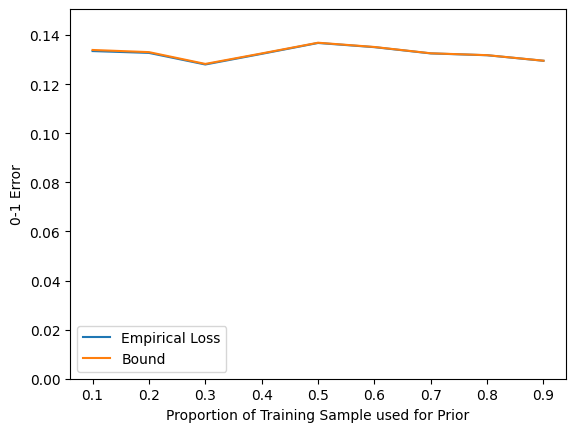

In [ ]:
plt.plot(ALPHA_VALUES,test_losses,label='Test Loss')
plt.plot(ALPHA_VALUES,empirical_losses,label='Empirical Loss')
plt.plot(ALPHA_VALUES,bounds,label='Bound')
plt.ylim((0,max(bounds)*1.1))
plt.ylabel('0-1 Error')
plt.xlabel('Proportion of Training Sample used for Prior')
plt.legend()
plt.savefig('plots/Info_Bounds_via_Bayes.png')